### 🔁 What is Iterative Retrieval in Agentic RAG?
Combined both Iterative And Self reflection

✅ Definition:
Iterative Retrieval is a dynamic strategy where an AI agent doesn't settle for the first batch of retrieved documents. Instead, it evaluates the adequacy of the initial context, and if necessary, it:

- Refines the query,
- Retrieves again,
- Repeats the process until it’s confident enough to answer the original question.

🧠 Why Use It?
In standard RAG:

- A single retrieval step is done, and the LLM uses it to answer.
- If the documents were incomplete or irrelevant, the answer may fail.

In Iterative RAG:

- The agent reflects on the retrieved content and the answer it produced.
- If it’s unsure, it can refine its search (like a human researcher would).

In [1]:
import os
from typing import List
from pydantic import BaseModel
from langchain.chat_models import init_chat_model
from langchain_openai import OpenAIEmbeddings
from langchain.schema import Document
from langchain.vectorstores import FAISS
from langchain_community.document_loaders import TextLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langgraph.graph import StateGraph, END

In [2]:
"""
STEP 3: Environment Setup
Load API credentials securely from environment variables.
"""

import os
from dotenv import load_dotenv

# Load environment variables from .env file
load_dotenv()

# Get Google API key with error handling
GOOGLE_API_KEY = os.getenv('GOOGLE_API_KEY')
if not GOOGLE_API_KEY:
    raise ValueError("GOOGLE_API_KEY not found in environment variables")
TAVILY_API_KEY = os.getenv('TAVILY_API_KEY')
if not TAVILY_API_KEY:
    raise ValueError("TAVILY_API_KEY not found in environment variables")
LANGSMITH_API_KEY = os.getenv('LANGSMITH_API_KEY')
if not LANGSMITH_API_KEY:
    raise ValueError("LANGSMITH_API_KEY not found in environment variables")

print("✓ API keys loaded successfully")

✓ API keys loaded successfully


In [3]:
from langchain_google_genai import GoogleGenerativeAIEmbeddings, ChatGoogleGenerativeAI

# Initialize Google embeddings model for vector representation
embedding_model = GoogleGenerativeAIEmbeddings(
    model="models/gemini-embedding-001", 
    google_api_key=GOOGLE_API_KEY
)


# Initialize Google's Gemini model for response generation
llm = ChatGoogleGenerativeAI(
    google_api_key=GOOGLE_API_KEY,
    model="gemini-2.0-flash",    # Latest fast Gemini model for quick reranking
    temperature=0,               # Deterministic output for consistency in ranking
    max_tokens=None,            # Use model default token limit
    timeout=None,               # No timeout limit for ranking requests
    max_retries=2,              # Retry failed requests twice
)

print("✓ Gemini model initialized for reranking")

✓ Gemini model initialized for reranking


/home/bjit/Desktop/Storage01/SelfDevelopment/Rag_Course/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
import time
from typing import List
from langchain_community.document_loaders import TextLoader,WebBaseLoader

# ----------------------------
# 1. Load and Embed Documents
# ----------------------------
urls = [
    "https://lilianweng.github.io/posts/2023-06-23-agent/",
    "https://lilianweng.github.io/posts/2024-04-12-diffusion-video/"
]
docs = []
for url in urls:
    docs.extend(WebBaseLoader(url).load())

splitter = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=50)
chunks = splitter.split_documents(docs)

print(f"Total chunks to embed: {len(chunks)}")

# Process chunks in batches to respect API rate limits
batch_size = 5  # Maximum 5 chunks per batch for free tier
delay_between_batches = 2.0  # 2 seconds delay between batches

embedding = embedding_model

# Create batches of chunks
chunk_batches = [chunks[i:i + batch_size] for i in range(0, len(chunks), batch_size)]

print(f"Processing {len(chunk_batches)} batches with {delay_between_batches}s delay between batches...")

# Process first batch to initialize vectorstore
print(f"Processing batch 1/{len(chunk_batches)} ({len(chunk_batches[0])} chunks)")
vectorstore = FAISS.from_documents(chunk_batches[0], embedding)

# Process remaining batches with delay
for i, batch in enumerate(chunk_batches[1:], 2):
    print(f"Waiting {delay_between_batches}s before processing batch {i}...")
    time.sleep(delay_between_batches)
    
    print(f"Processing batch {i}/{len(chunk_batches)} ({len(batch)} chunks)")
    batch_vectorstore = FAISS.from_documents(batch, embedding)
    
    # Merge with main vectorstore
    vectorstore.merge_from(batch_vectorstore)

retriever = vectorstore.as_retriever()
print("✓ All chunks embedded and vectorstore created successfully")

USER_AGENT environment variable not set, consider setting it to identify your requests.


Total chunks to embed: 234
Processing 47 batches with 2.0s delay between batches...
Processing batch 1/47 (5 chunks)
Waiting 2.0s before processing batch 2...
Processing batch 2/47 (5 chunks)
Waiting 2.0s before processing batch 3...
Processing batch 3/47 (5 chunks)
Waiting 2.0s before processing batch 4...
Processing batch 4/47 (5 chunks)
Waiting 2.0s before processing batch 5...
Processing batch 5/47 (5 chunks)
Waiting 2.0s before processing batch 6...
Processing batch 6/47 (5 chunks)
Waiting 2.0s before processing batch 7...
Processing batch 7/47 (5 chunks)
Waiting 2.0s before processing batch 8...
Processing batch 8/47 (5 chunks)
Waiting 2.0s before processing batch 9...
Processing batch 9/47 (5 chunks)
Waiting 2.0s before processing batch 10...
Processing batch 10/47 (5 chunks)
Waiting 2.0s before processing batch 11...
Processing batch 11/47 (5 chunks)
Waiting 2.0s before processing batch 12...
Processing batch 12/47 (5 chunks)
Waiting 2.0s before processing batch 13...
Processin

In [6]:
### Define Agent State

class IterativeRAGState(BaseModel):
    question: str
    refined_question: str = ""
    retrieved_docs: List[Document] = []
    answer: str = ""
    verified: bool = False
    attempts: int = 0


In [7]:
### Retrieve Node
def retrieve_docs(state: IterativeRAGState) -> IterativeRAGState:
    query = state.refined_question or state.question
    docs = retriever.invoke(query)
    return state.model_copy(update={"retrieved_docs": docs})

In [8]:
### Reflect And Verify
def generate_answer(state: IterativeRAGState) -> IterativeRAGState:
    
    context = "\n\n".join(doc.page_content for doc in state.retrieved_docs)
    prompt = f"""Use the following context to answer the question:

Context:
{context}

Question:
{state.question}
"""
    response = llm.invoke(prompt.strip()).content.strip()
    return state.model_copy(update={"answer": response, "attempts": state.attempts + 1})

In [9]:
## Reflect on answer
def reflect_on_answer(state: IterativeRAGState) -> IterativeRAGState:
    
    prompt = f"""
Evaluate whether the answer below is factually sufficient and complete.

Question: {state.question}
Answer: {state.answer}

Respond 'YES' if it's complete, otherwise 'NO' with feedback.
"""
    feedback = llm.invoke(prompt).content.lower()
    verified = "yes" in feedback
    return state.model_copy(update={"verified": verified})


In [10]:
## Refine query
def refine_query(state: IterativeRAGState) -> IterativeRAGState:
    
    prompt = f"""
The answer appears incomplete. Suggest a better version of the query that would help retrieve more relevant context.

Original Question: {state.question}
Current Answer: {state.answer}
"""
    new_query = llm.invoke(prompt).content.strip()
    return state.model_copy(update={"refined_question": new_query})


In [14]:
def decide_next_step(state: IterativeRAGState) -> str:
    """
    Decision function for conditional routing after reflection.
    
    Returns:
        - END: If answer is verified or max attempts reached
        - "refine": If answer needs improvement and attempts < 2
    """
    if state.verified or state.attempts >= 2:
        return END
    else:
        return "refine"

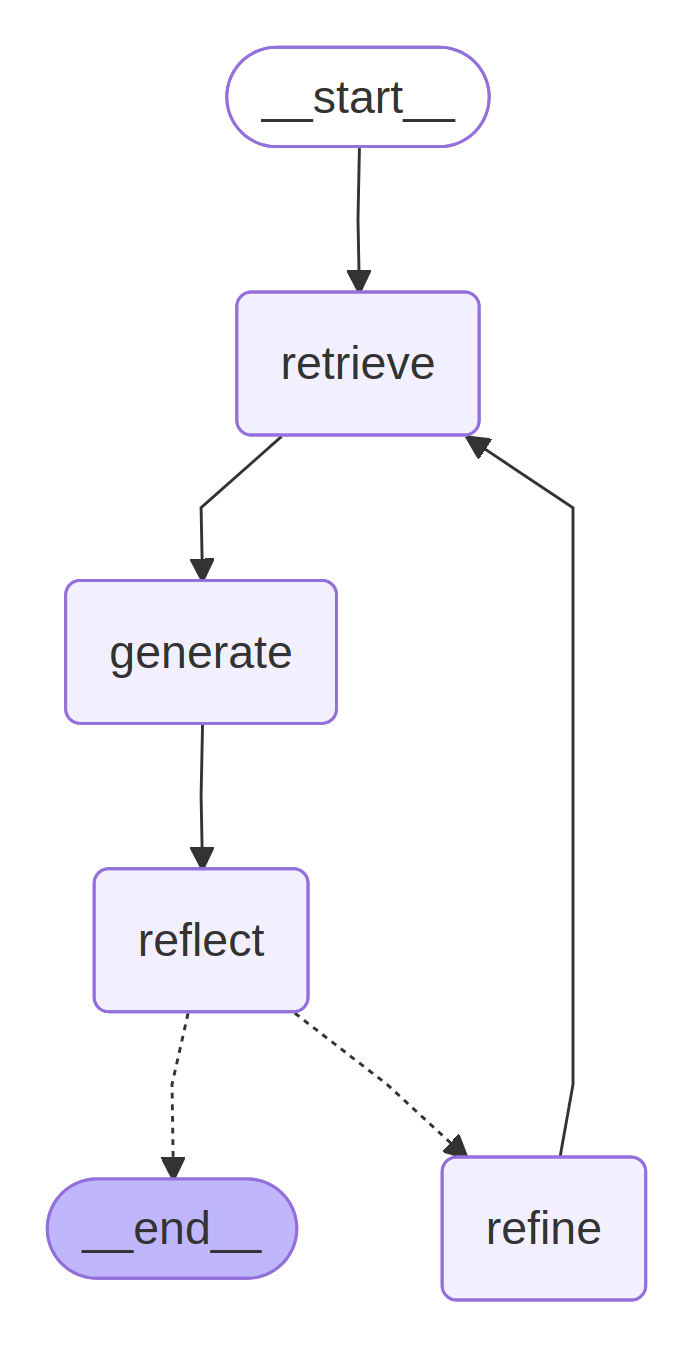

In [15]:
from langchain_core.runnables.graph import MermaidDrawMethod 

import nest_asyncio
nest_asyncio.apply()

# ----------------------------
# 4. Build LangGraph
# ----------------------------
"""
Constructs the Iterative Retrieval RAG workflow graph with four nodes:
1. retrieve: Gets relevant documents based on query
2. generate: Creates answer from retrieved context
3. reflect: Evaluates answer quality and completeness
4. refine: Improves query if answer is insufficient

Note: Node names must not conflict with state field names.
"""

builder = StateGraph(IterativeRAGState)

# Add workflow nodes with unique names
builder.add_node("retrieve", retrieve_docs)
builder.add_node("generate", generate_answer)
builder.add_node("reflect", reflect_on_answer)
builder.add_node("refine", refine_query)

# Define workflow execution path
builder.set_entry_point("retrieve")
builder.add_edge("retrieve", "generate")
builder.add_edge("generate", "reflect")

# Conditional logic: continue iterating or end based on verification/attempts
builder.add_conditional_edges(
    "reflect",
    decide_next_step,
    {
        END: END,
        "refine": "refine"
    }
)

# Complete the iteration loop
builder.add_edge("refine", "retrieve")

# Compile the graph for execution
graph = builder.compile()

# Visualize the workflow graph
from IPython.display import Image, display
display(Image(graph.get_graph(xray=True).draw_mermaid_png(draw_method=MermaidDrawMethod.PYPPETEER)))

In [17]:
query = "Explain how agent loops work and what are the challenges in diffusion video generation?"

initial_state = IterativeRAGState(question=query)
final = graph.invoke(initial_state)

print("✅ Final Answer:\n", final["answer"])
print("\n🧠 Verified:", final["verified"])
print("🔁 Attempts:", final["attempts"])

✅ Final Answer:
 The provided context doesn't explain how agent loops work. It focuses on the challenges of diffusion video generation.

Here's a breakdown of the challenges in diffusion video generation, based on the context:

*   **Temporal Consistency:** Video generation requires maintaining consistency across frames over time. This means the generated video needs to be coherent and avoid jarring transitions or illogical changes. Achieving this requires the model to understand and encode a significant amount of "world knowledge" to ensure realistic and plausible video sequences.

*   **Data Scarcity:** Collecting large, high-quality video datasets, especially with paired text descriptions, is difficult. This limits the amount of training data available for diffusion models, which typically benefit from massive datasets.

*   **Upsampling Complexity:** Diffusion models for video generation often need to perform multiple upsampling steps to increase video length or frame rate. This re